In [1]:
import os
import numpy as np
import pandas as pd
import time
import warnings

from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score


### Data Preprocessing

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


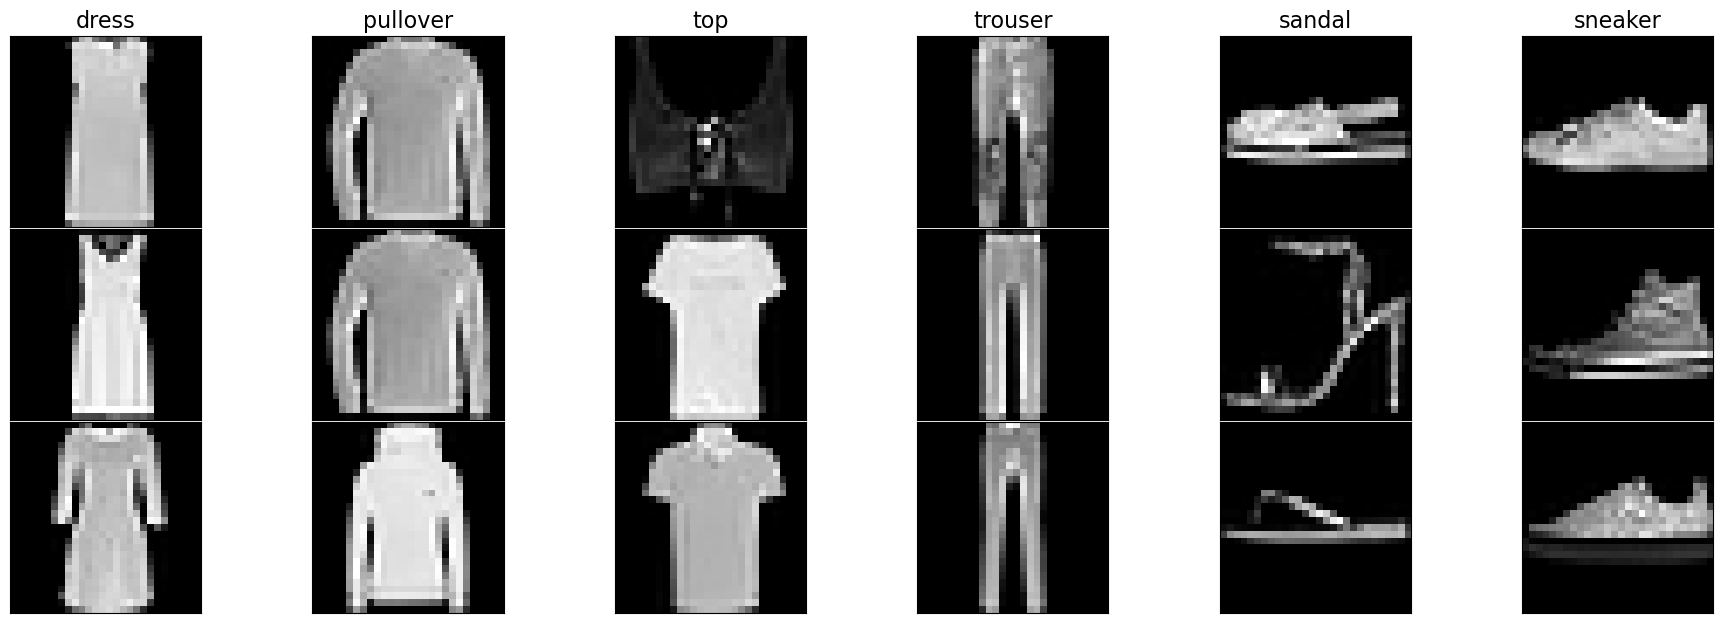

In [2]:
%run load_and_plot_data.py

In [3]:
train_y_df, valid_y_df

(     class_name  class_uid
 0      pullover          2
 1           top          0
 2         dress          3
 3        sandal          5
 4      pullover          2
 ...         ...        ...
 2097     sandal          5
 2098     sandal          5
 2099     sandal          5
 2100     sandal          5
 2101     sandal          5
 
 [2102 rows x 2 columns],
     class_name  class_uid
 0        dress          3
 1        dress          3
 2        dress          3
 3        dress          3
 4        dress          3
 ..         ...        ...
 595    sneaker          7
 596    sneaker          7
 597        top          0
 598        top          0
 599    trouser          1
 
 [600 rows x 2 columns])

In [4]:
temp = np.array(train_y_df)
count_array = temp[:,1]
count_train = np.unique(count_array, return_counts = True)

temp = np.array(valid_y_df)
count_array = temp[:,1]
count_valid = np.unique(count_array, return_counts = True)

In [5]:
count_train, count_valid

((array([0, 1, 2, 3, 5, 7], dtype=object),
  array([  1,   1, 100, 400, 800, 800])),
 (array([0, 1, 2, 3, 5, 7], dtype=object),
  array([100, 100, 100, 100, 100, 100])))

In [6]:
train_y = np.array(train_y_df['class_uid'])
train_y

array([2, 0, 3, ..., 5, 5, 5])

In [8]:
train_x.shape, train_x[0].dtype

((2102, 784), dtype('int64'))

In [9]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(train_x)
print(np.sum(scaler.transform(train_x)))

301797.8567070458


In [10]:
normed_train_x = sklearn.preprocessing.normalize(train_x, norm = 'l1', axis = 1)
normed_train_x

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00524109, 0.00184232,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00488135, 0.00526799,
        0.        ]])

In [11]:
mlp = MLPClassifier(
            activation='relu',
            alpha=0.0001,
            max_iter=2000,
            solver='sgd',
            learning_rate='adaptive', 
            momentum=0.0,
            tol=1e-5,
            n_iter_no_change=50,
            )

In [14]:
mlp_hyperparameter_grid = dict(
    hidden_layer_sizes = [32, 64, 128],
    random_state = [101],
    batch_size= [5, 100, 1000],
    learning_rate_init=[0.001, 0.005, 0.0001, 0.0005], 
    )

In [15]:
valid_y = np.array(valid_y_df['class_uid'])
valid_y.shape, train_y.shape

((600,), (2102,))

### fit on valid + train

In [16]:
x_all = np.vstack([train_x, valid_x])
y_all = np.hstack([train_y, valid_y])

In [17]:
### splitter
valid_indicators_L = np.hstack([
    -1 * np.ones(train_y.size), # -1 means never include this example in any test split
    0  * np.ones(valid_y.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_L)

In [18]:
mlp_searcher = sklearn.model_selection.GridSearchCV(estimator = mlp,
                                                    param_grid = mlp_hyperparameter_grid,
                                                    scoring = 'balanced_accuracy',
                                                    cv = my_splitter,
                                                    return_train_score = True,
                                                    refit=False
                                                   )

In [19]:
start_time_sec = time.time()
mlp_searcher.fit(x_all, y_all)
elapsed_time_sec = time.time() - start_time_sec

/Users/richardwang/micromamba/envs/cs135_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [18]:
mlp_searcher_result = pd.DataFrame(mlp_searcher.cv_results_).copy()
mlp_searcher_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_hidden_layer_sizes,param_learning_rate_init,param_random_state,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,162.116306,0.0,0.012794,0.0,100,32,0.001,101,"{'batch_size': 100, 'hidden_layer_sizes': 32, ...",0.636667,0.636667,0.0,1,0.992708,0.992708,0.0
1,34.216424,0.0,0.004828,0.0,100,32,0.005,101,"{'batch_size': 100, 'hidden_layer_sizes': 32, ...",0.308333,0.308333,0.0,4,0.323542,0.323542,0.0
2,77.305297,0.0,0.004700,0.0,100,32,0.0001,101,"{'batch_size': 100, 'hidden_layer_sizes': 32, ...",0.616667,0.616667,0.0,3,1.000000,1.000000,0.0
3,49.619134,0.0,0.001984,0.0,100,32,0.0005,101,"{'batch_size': 100, 'hidden_layer_sizes': 32, ...",0.635000,0.635000,0.0,2,0.996667,0.996667,0.0


In [19]:
mlp_searcher.best_params_

{'batch_size': 100,
 'hidden_layer_sizes': 32,
 'learning_rate_init': 0.001,
 'random_state': 101}

In [ ]:
# batch_size = 100

# max_iter_per_run = 2000 # Don't touch. Has been set so wallclock times are comparable.

# lr_list = [0.001, 0.0001, 0.0005, 0.005]
# n_runs = 1
# mlp_list_by_lr_500 = dict()



# for lr in lr_list:
#     mlp_list_by_lr_500[lr] = list()
#     for run_id, random_state in enumerate(range(n_runs)):
#         start_time_sec = time.time()
#         mlp = MLPClassifier(
#             hidden_layer_sizes = [64],
#             activation='relu',
#             alpha=0.0001,
#             random_state=random_state, # controls random init of weights
#             max_iter=max_iter_per_run,
#             solver='sgd',
#             batch_size=batch_size,
#             learning_rate='adaptive', learning_rate_init=lr, momentum=0.0,
#             tol=1e-5,
#             n_iter_no_change=50,
#             )

#         with warnings.catch_warnings(record=True) as warn_list:
#             mlp.fit(train_x, train_y)
#         mlp.elapsed_time_sec_ = time.time() - start_time_sec
#         mlp.n_epoch_ = len(mlp.loss_curve_)
#         mlp.did_converge = True if len(warn_list) == 0 else False
        
#         # Add to the list
#         mlp_list_by_lr_500[lr].append(mlp)
        
#         pred_y = mlp.predict(train_x)
#         print(pred_y[:5])
#         print(pred_y[5:])
        
#         print(np.unique(pred_y, return_counts = True))
        
#         # Pretty print summary of this run
#         print('finished run %2d/%d after %5.1f sec | %13s after %4d iter | tr loss % .3f | balacc % .3f | lr = %.3f' % (
#             run_id + 1, n_runs,
#             mlp.elapsed_time_sec_,
#             'yes converged' if mlp.did_converge else 'NOT converged',
#             mlp.n_epoch_,
#             mlp.loss_ / np.log(2.0),
#             balanced_accuracy_score(train_y, pred_y),
#             lr))